/tmp/ipykernel_393840/4047525783.py:158: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab10", M) if M <= 10 else get_cmap("tab20", M)


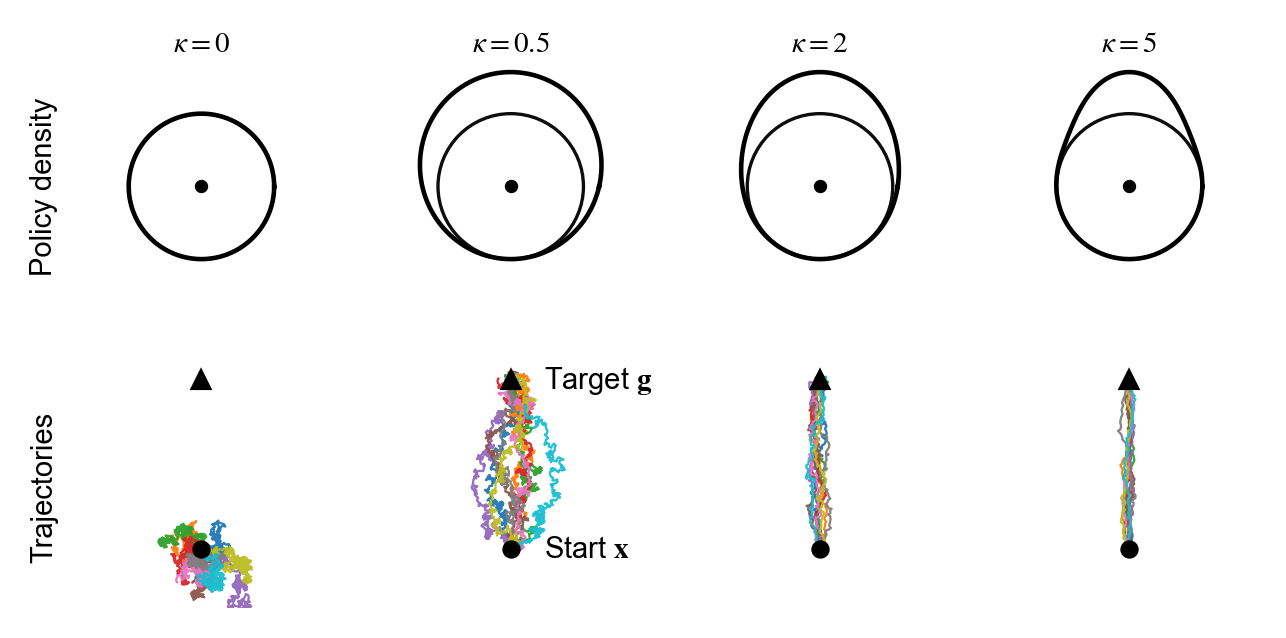

Saved figure to: figures/vonmises_navigation.pdf
Saved figure to: figures/vonmises_navigation.svg


In [20]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.cm import get_cmap

# -----------------------------
# Global style
#   - ALL normal text (labels, numbers) = Arial
#   - ALL math (kappa, x, g) = STIX
# -----------------------------
DPI       = 300
FONT_SIZE = 7
AX_LW     = 0.8
LINE_LW   = 1.0
TICK_LW   = 0.8
TICK_LEN  = 2.5

mpl.rcParams.update({
    "text.usetex": False,

    # Normal text
    "font.family": "Arial",

    # Math text (kappa, x, g, etc.)
    "mathtext.fontset": "stix",
    "mathtext.default": "it",

    "font.size": FONT_SIZE,
    "axes.labelsize": FONT_SIZE,
    "axes.titlesize": FONT_SIZE,
    "legend.fontsize": FONT_SIZE,
    "xtick.labelsize": FONT_SIZE,
    "ytick.labelsize": FONT_SIZE,

    "axes.linewidth": AX_LW,
    "lines.linewidth": LINE_LW,

    "xtick.major.width": TICK_LW,
    "ytick.major.width": TICK_LW,
    "xtick.major.size":  TICK_LEN,
    "ytick.major.size":  TICK_LEN,

    "savefig.dpi": DPI,
    "figure.dpi": DPI,

    # Keep Arial as editable text in PDFs
    "pdf.fonttype": 42,
    "ps.fonttype": 42,

    # If you import SVG into Inkscape, paths are most robust
    "svg.fonttype": "path",
})

# -----------------------------
# Config
# -----------------------------
x_start = np.array([0.0, 0.0], dtype=np.float32)
target  = np.array([0.0, 10.0], dtype=np.float32)

kappas = np.array([0, 0.5, 2, 5], dtype=np.float32)

T_steps  = 300
step_len = 0.15
num_traj = 10
rng_seed = 12345

R_policy = 1.75
amp      = 1.0

out_dir  = "figures"
out_name = "vonmises_navigation.pdf"
os.makedirs(out_dir, exist_ok=True)
save_path = os.path.join(out_dir, out_name)
save_path_svg = os.path.join(out_dir, "vonmises_navigation.svg")

# -----------------------------
# Helpers
# -----------------------------
def goal_heading(x, y):
    d = y - x
    return np.arctan2(d[1], d[0])

def vonmises_pdf(theta, mu, kappa):
    return np.exp(kappa * np.cos(theta - mu)) / (2.0 * np.pi * np.i0(kappa))

def _clean_axis(ax):
    ax.set_xticks([])
    ax.set_yticks([])
    for sp in ax.spines.values():
        sp.set_visible(False)

# -----------------------------
# Figure: top row PDFs, bottom row trajectories
# -----------------------------
n = len(kappas)
fig, axes = plt.subplots(
    2, n,
    figsize=(1.10 * n, 2.20),   # more compact overall
    dpi=DPI,
    squeeze=False,
)

theta_grid = np.linspace(0, 2*np.pi, 1024, endpoint=False)
mu0 = goal_heading(x_start, target)

# --- Make top row compact: show goal direction with a marker on the ring,
#     NOT the literal target at y=10 (which creates huge whitespace).
Rmax = R_policy + amp
goal_dir = np.array([np.cos(mu0), np.sin(mu0)], dtype=np.float32)
target_top = x_start + (Rmax + 0.22) * goal_dir  # just outside the policy curve

# -------- Row 0: exact von Mises PDF rendered as a radial modulation --------
for i, kappa in enumerate(kappas):
    ax = axes[0, i]

    pdf = vonmises_pdf(theta_grid, mu=mu0, kappa=float(kappa)).astype(np.float32)
    pdf_norm = (pdf - pdf.min()) / (pdf.max() - pdf.min() + 1e-12)

    rad = R_policy + amp * pdf_norm
    xs = x_start[0] + rad * np.cos(theta_grid)
    ys = x_start[1] + rad * np.sin(theta_grid)

    ax.plot(xs, ys, color="k", lw=1.1, zorder=3)
    ax.add_patch(Circle(xy=x_start, radius=R_policy, fill=False, lw=AX_LW, ec="k", alpha=0.95))

    ax.plot(x_start[0], x_start[1], "o", ms=2.2, c="k", zorder=5)

    ax.set_title(rf"$\kappa={float(kappa):g}$", pad=2)

    ax.set_aspect("equal", adjustable="box")
    _clean_axis(ax)

    pad = 0.30
    ax.set_xlim(x_start[0] - Rmax - pad, x_start[0] + Rmax + pad)
    ax.set_ylim(x_start[1] - Rmax - pad, x_start[1] + Rmax + pad)

# -------- Row 1: trajectories by stepwise von Mises sampling --------
label_idx = 1

for i, kappa in enumerate(kappas):
    ax = axes[1, i]

    rng = np.random.default_rng(rng_seed + i)
    M = num_traj
    pos = np.empty((T_steps + 1, M, 2), dtype=np.float32)
    pos[0, :, :] = x_start[None, :]

    for t in range(T_steps):
        x_t = pos[t]
        mu_t = np.arctan2(target[None, 1] - x_t[:, 1], target[None, 0] - x_t[:, 0])
        th_t = rng.vonmises(mu=mu_t, kappa=float(kappa), size=M).astype(np.float32)

        step = np.stack([np.cos(th_t), np.sin(th_t)], axis=-1) * step_len
        pos[t + 1] = x_t + step

    cmap = get_cmap("tab10", M) if M <= 10 else get_cmap("tab20", M)
    for j in range(M):
        ax.plot(pos[:, j, 0], pos[:, j, 1], lw=0.55, alpha=0.95, color=cmap(j), zorder=2)

    ax.plot(x_start[0], x_start[1], "o", ms=3.4, c="k", zorder=5)
    ax.plot(target[0],  target[1],  "^", ms=4.0, c="k", zorder=5)

    if i == label_idx:
        ax.annotate(r"Start $\mathbf{x}$",
                    xy=(x_start[0], x_start[1]),
                    xytext=(8, 0), textcoords="offset points",
                    ha="left", va="center")
        ax.annotate(r"Target $\mathbf{g}$",
                    xy=(target[0], target[1]),
                    xytext=(8, 0), textcoords="offset points",
                    ha="left", va="center")

    ax.set_aspect("equal", adjustable="box")
    _clean_axis(ax)

    # slightly tighter than before
    ax.set_xlim(-7.5, 7.5)
    ax.set_ylim(-3.5, 10.8)

# Row labels (Arial)
axes[0, 0].set_ylabel("Policy density", labelpad=4)
axes[1, 0].set_ylabel("Trajectories",  labelpad=4)

# Compact spacing between panels/rows
fig.subplots_adjust(left=0.10, right=0.995, bottom=0.06, top=0.93, wspace=0.22, hspace=0.10)

fig.savefig(save_path, bbox_inches="tight")
fig.savefig(save_path_svg, bbox_inches="tight")  # optional but super robust for Inkscape
plt.show()

print(f"Saved figure to: {save_path}")
print(f"Saved figure to: {save_path_svg}")
